# Training generative model

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformer import GPTModel

# Evaluating generative text models

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [4]:
# Greedy decoding

def generate_text_simple(model, idx, max_new_tokens, context_size): # idx - [batch, n_tokens]
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # crops current context in order to comply with the available context window
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]  # chose last vector of vocab_size corresponding to the next token probability distribution
        probas = torch.softmax(logits, dim = -1)
        idx_next = torch.argmax(probas, dim = -1, keepdim = True)
        idx = torch.cat((idx, idx_next), dim = 1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Create batch dimension in order to comply with models
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## Calculating the text generation loss: cross-entropy and perplexity

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [7]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


Calculations performed by model expose probability distribution over all token vocabulary.

In [8]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [9]:
# The token probabilities corresponding to the target indices are as follows:

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [10]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)


- The goal is to make this average log probability as large as possible by optimizing the model weights
- Due to the `log`, the largest possible value is 0, and we are currently far away from 0
- In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
- The value negative of -10.7722, i.e., 10.7722, is also called **cross-entropy loss** in deep learning

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- We can use PyTorch's `cross-entropy` loss for this simple task:

In [12]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the `cross_entropy` function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)


Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- Targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize
- The `cross_entropy` function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- A concept related to the `cross-entropy loss` is the `perplexity` of an LLM
- The `perplexity` is simply the exponential of the cross-entropy loss
$$PP(w) = \sqrt[k]{\frac{1}{\prod_{i=0}^{k} P(w_i|w_{i-1},...,w_0)}} = \exp{\biggr(-\frac{1}{k}\sum_{i=0}^{k} \log [P_{\theta}(w_i|w_{i-1},...,w_0)] \biggl)}$$

In [15]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- The `perplexity` is often considered more interpretable because it can be understood as the *effective vocabulary size that the model is uncertain about at each step* (in the example above, that'd be 52,918 words or tokens)
- Perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset
- Similar to the loss, a *lower perplexity* indicates that the *model predictions are closer to the actual distribution*

## Calculating the training and validation set losses

In [16]:
file_path = os.path.join("data", "the-verdict.txt")
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [17]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- We divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the max_length equal to the context length that the LLM supports
- The figure below only shows the input tokens for simplicity
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

![img](https://camo.githubusercontent.com/4d6c167e344077ad4c3b94cbbd6a9059589021bec84fa280dd552bfcddeb4918/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f6261746368696e672e77656270)

In [19]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [20]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")


In [21]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [22]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [23]:
# Loss calculation per batch

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


# Training an LLM

In [25]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, 50, context_size)

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

def train_model_simple(model, train_loader, val_loader,
                      optimizer, device, num_epochs,
                      eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [74]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.813, Val loss 9.921
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.334
very effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.046                   

5): Train loss 6.048, Val loss 6.600                   


Every effort moves you, and,, and,,,,,,, and,.                                   
p 3 (Step 000020): Train loss 5.580, Val loss 6.484                             

Ep 3 (Step 000025): Train loss 5.504, Val loss 6.402                            


very effort moves you, and, and of the of the of the, and I had. G. Gis, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 5.079, Val loss 6.319, and I had. G. Gis, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,

5): Train loss 4.826, Val loss 6.311, and I had. G. Gis, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,


Every effort 

In [75]:
generate_and_print_sample(model, tokenizer, 'cuda', 'Streets are fantastic')

Streets are fantastic thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in


### Text generation strategies

Text generation can be done using multiple strategies that differ by degree of randomness. There exist multiple strategies that can be implemented for text generation:
- Simple text generation (*dummy* generation) that uses brute-force;
- *Temperature scaling* enhanced technique that implements randomization by scaling tokens logits in orded to create sharp or more uniform token probabilities distributions;
- *Top-k sampling*.

#### Temperature scaling demo

In [35]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

In [37]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

# Simple approach
probas = torch.softmax(next_token_logits, dim = -1)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

# Random approach
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples = 1).item()
print(inverse_vocab[next_token_id])

forward
toward


In [38]:
# Showcase of this strategy

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
             for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


If we include temperature scaling we would tune our probability distribution and create a more diverse or more sharp distribution:

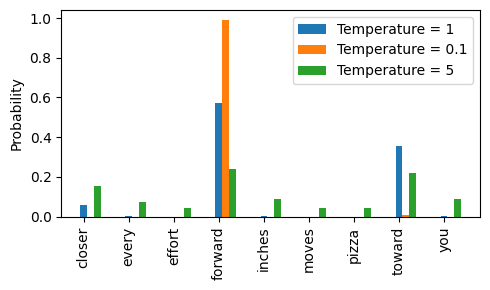

In [41]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]                                     #1
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

**Decreasing the temperature to 0.1 sharpens the distribution, so the most likely token (here, “forward”) will have an even higher probability score. Likewise, increasing the temperature to 5 makes the distribution more uniform.**

#### Top-k sampling demo

Top-k sampling, when combined with probabilistic sampling and temperature scaling, can improve the text generation results. In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probability scores.

In [44]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)
print("Top tokens", [inverse_vocab[i] for i in top_pos.numpy()])

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
Top tokens ['forward', 'toward', 'closer']


In [48]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)
print("Masked token logits:", new_logits)

topk_probas = torch.softmax(new_logits, dim=0)
print("New tokens distribution:", topk_probas)

Masked token logits: tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
New tokens distribution: tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


#### Combined function for text generation

In [80]:
def generate(model, idx, max_new_tokens, context_size,
            temperature = 0.0, top_k = None, eos_ind = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # Top-k sampling
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        
        # Temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)
        else:
            idx_next = torch.argmax(logits, dim = -1, keepdim = True)
        
        if idx_next == eos_ind:
            break
        idx = torch.cat((idx, idx_next), dim = 1)
    return idx

In [85]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=30,
    temperature=1.2

)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me."

He laughed again, and threw back his head to look up at the sketch of the sketch of the bull--that I found
